<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM Àrea 4 · NLP & Text Mining</p>
<p style="margin: 0; text-align:right;">2022 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="row" style="padding-top: 50px;">
    <div class="row" style="background: #494949;padding: 10px 20px; color: #FFF">
        <div class="col-md-12">
            <div style="text-align:left;"><b>Estudiant:</b> Albert Cámara Viñals</div>
        </div>
    </div>
</div>

## T5 - Information Extraction from *synthetic invoice dataset* with *GraphSAGE* model

## **Information extraction**

> Information extraction (IE) is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources. In most of the cases this activity concerns processing images by means computer vision (CV) and processing human language texts by means of natural language processing (NLP).

In [1]:
# Load libraries
import networkx as nx
import pandas as pd
import pickle
import numpy as np
import itertools
import os
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from stellargraph import StellarGraph as sg
from stellargraph import globalvar
from stellargraph import utils
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.model_selection import train_test_split
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

## Data Objects

**Define some data models**

In [2]:
class NetworkData():
    
    def __init__(self, final_connections, G, df):
        self.final_connections = final_connections
        self.G = G
        self.df = df
        
    def get_processed_data(self):
        return self.df
    
    def get_relationships(self):
        return self.final_connections
    
    def get_networkx_graph(self):
        return self.G

## Modeling

**Prepare data to load into StellarGraph model**

In [3]:
# Define some directories
data_dir = './data/'
dataset_path = './data/synthetic_invoice/'
models_dir = './models/'

In [4]:
# Read union of all documents graphs as a NetworkX from file for Train-Test Set
networkx_file = open(os.path.join(dataset_path, 'documents_union_networkx_311_features.pickle'), "rb")
U = pickle.load(networkx_file)
networkx_file.close()
print(U)

Graph with 338757 nodes and 504449 edges


In [5]:
# Load data directly from Networkx into StellarGraph
graph_full = sg.from_networkx(U, node_features="feature")

# Show graph info
print(graph_full.info())

StellarGraph: Undirected multigraph
 Nodes: 338757, Edges: 504449

 Node types:
  default: [338757]
    Features: float32 vector, length 311
    Edge types: default-default->default

 Edge types:
    default-default->default: [504449]
        Weights: all 1 (default)
        Features: none


In [6]:
# Read all individual documents graph Networkx of Train Set
nx_train_file = open(os.path.join(dataset_path, 'train_documents_networkx_311_features.pickle'), "rb")
nx_train = pickle.load(nx_train_file)
nx_train_file.close()
print('Number of document networks on Train Set:', len(nx_train))

# Get labels for each node on Train Set

# Get labels of NetworkData
labels_train = [network.df[['node_id', 'tag']] for network in nx_train]
tagged_data_train = pd.concat(labels_train, sort=False)
tagged_data_train.rename(columns = {'tag': 'node_target'}, inplace = True)

train = tagged_data_train

# Show number of Labels
print('Number of labels on Train Set:', len(tagged_data_train))

Number of document networks on Train Set: 700
Number of labels on Train Set: 136077


In [7]:
# Read all individual documents graph Networkx of Validation Set
nx_val_file = open(os.path.join(dataset_path, 'val_documents_networkx_311_features.pickle'), "rb")
nx_val = pickle.load(nx_val_file)
nx_val_file.close()
print('Number of document networks on Validation Set:', len(nx_val))

# Get labels for each node on Validation Set

# Get labels of NetworkData
labels_val = [network.df[['node_id', 'tag']] for network in nx_val]
tagged_data_val = pd.concat(labels_val, sort=False)
tagged_data_val.rename(columns = {'tag':'node_target'}, inplace = True)

val = tagged_data_val

print('Number of labels on Validation Set:', len(tagged_data_val))

Number of document networks on Validation Set: 700
Number of labels on Validation Set: 134601


In [8]:
# Read all individual documents graph Networkx of Test Set
nx_test_file = open(os.path.join(dataset_path, 'test_documents_networkx_311_features.pickle'), "rb")
nx_test = pickle.load(nx_test_file)
nx_test_file.close()
print('Number of document networks on Test Set:', len(nx_test))

# Get labels for each node on Test Set

# Get labels of NetworkData
labels_test = [network.df[['node_id', 'tag']] for network in nx_test]
tagged_data_test = pd.concat(labels_test, sort=False)
tagged_data_test.rename(columns = {'tag':'node_target'}, inplace = True)

test = tagged_data_test

# Show number of Labels
print('Number of labels on Test Set:', len(tagged_data_test))

Number of document networks on Test Set: 350
Number of labels on Test Set: 68079


In [9]:
# Read union of all documents graphs as a NetworkX from file for Train Set
networkx_file = open(os.path.join(dataset_path, 'train_documents_union_networkx_311_feaures.pickle'), "rb")
U_train = pickle.load(networkx_file)
networkx_file.close()
print(U_train)

Graph with 136077 nodes and 202702 edges


In [10]:
# Read union of all documents graphs as a NetworkX from file for Validation Set
networkx_file = open(os.path.join(dataset_path, 'val_documents_union_networkx_311_features.pickle'), "rb")
U_val = pickle.load(networkx_file)
networkx_file.close()
print(U_val)

Graph with 134601 nodes and 200308 edges


In [11]:
# Union of multiple documents graphs on Train, Validation & Set
U = nx.union_all([U_train, U_val])

print(U)

# Save union of all documents graphs as a Networkx on Train, Validation & Test Set to a file
nx_file = open(os.path.join(dataset_path, 'trainval_documents_union_networkx_311_features.pickle'), "wb")
pickle.dump(U, nx_file)
nx_file.close()

Graph with 270678 nodes and 403010 edges


In [12]:
graph_sampled = sg.from_networkx(U, node_features="feature")
print(graph_sampled.info())

StellarGraph: Undirected multigraph
 Nodes: 270678, Edges: 403010

 Node types:
  default: [270678]
    Features: float32 vector, length 311
    Edge types: default-default->default

 Edge types:
    default-default->default: [403010]
        Weights: all 1 (default)
        Features: none


In [13]:
# Encoding the targets
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train.node_target)
val_targets = target_encoding.fit_transform(val.node_target)
test_targets = target_encoding.fit_transform(test.node_target)

# Examine size
print('Train:', train.shape, train_targets.shape)
print('Validation:', val.shape, val_targets.shape)
print('Test:', test.shape, test_targets.shape)

Train: (136077, 2) (136077, 29)
Validation: (134601, 2) (134601, 29)
Test: (68079, 2) (68079, 29)


In [14]:
batch_size = 50
num_samples = [10, 10]

In [15]:
# Create a generator function to generate batches of nodes given the Stellar Network Graph.
generator = GraphSAGENodeGenerator(graph_sampled, batch_size, num_samples)

In [16]:
# Call the flow function and pass the target label and the nodes to get an object that can be used as a Keras data generator.
train_gen = generator.flow(train.node_id, train_targets, shuffle=True)
val_gen = generator.flow(val.node_id, val_targets)

**Build model**

In [17]:
# Model Formation Graph Sage

def build_graph_sage_model(learning_rate):
    # create layers
    graphsage_model = GraphSAGE(layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5)
    
    # expose in and out to create keras model
    x_inp, x_out = graphsage_model.in_out_tensors()
    
    # usual output layer
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
    
    # define model
    model = Model(inputs=x_inp, outputs=prediction)

    # compile model
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=losses.categorical_crossentropy, metrics=["accuracy"])

    return model

# Build the GraphSAGE model
graph_sage_model = build_graph_sage_model(0.005)

In [18]:
# Validate model blocks
print(graph_sage_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 311)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 311)]   0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1, 311)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 10, 311)   0           ['input_2[0][0]']                
                                                                                              

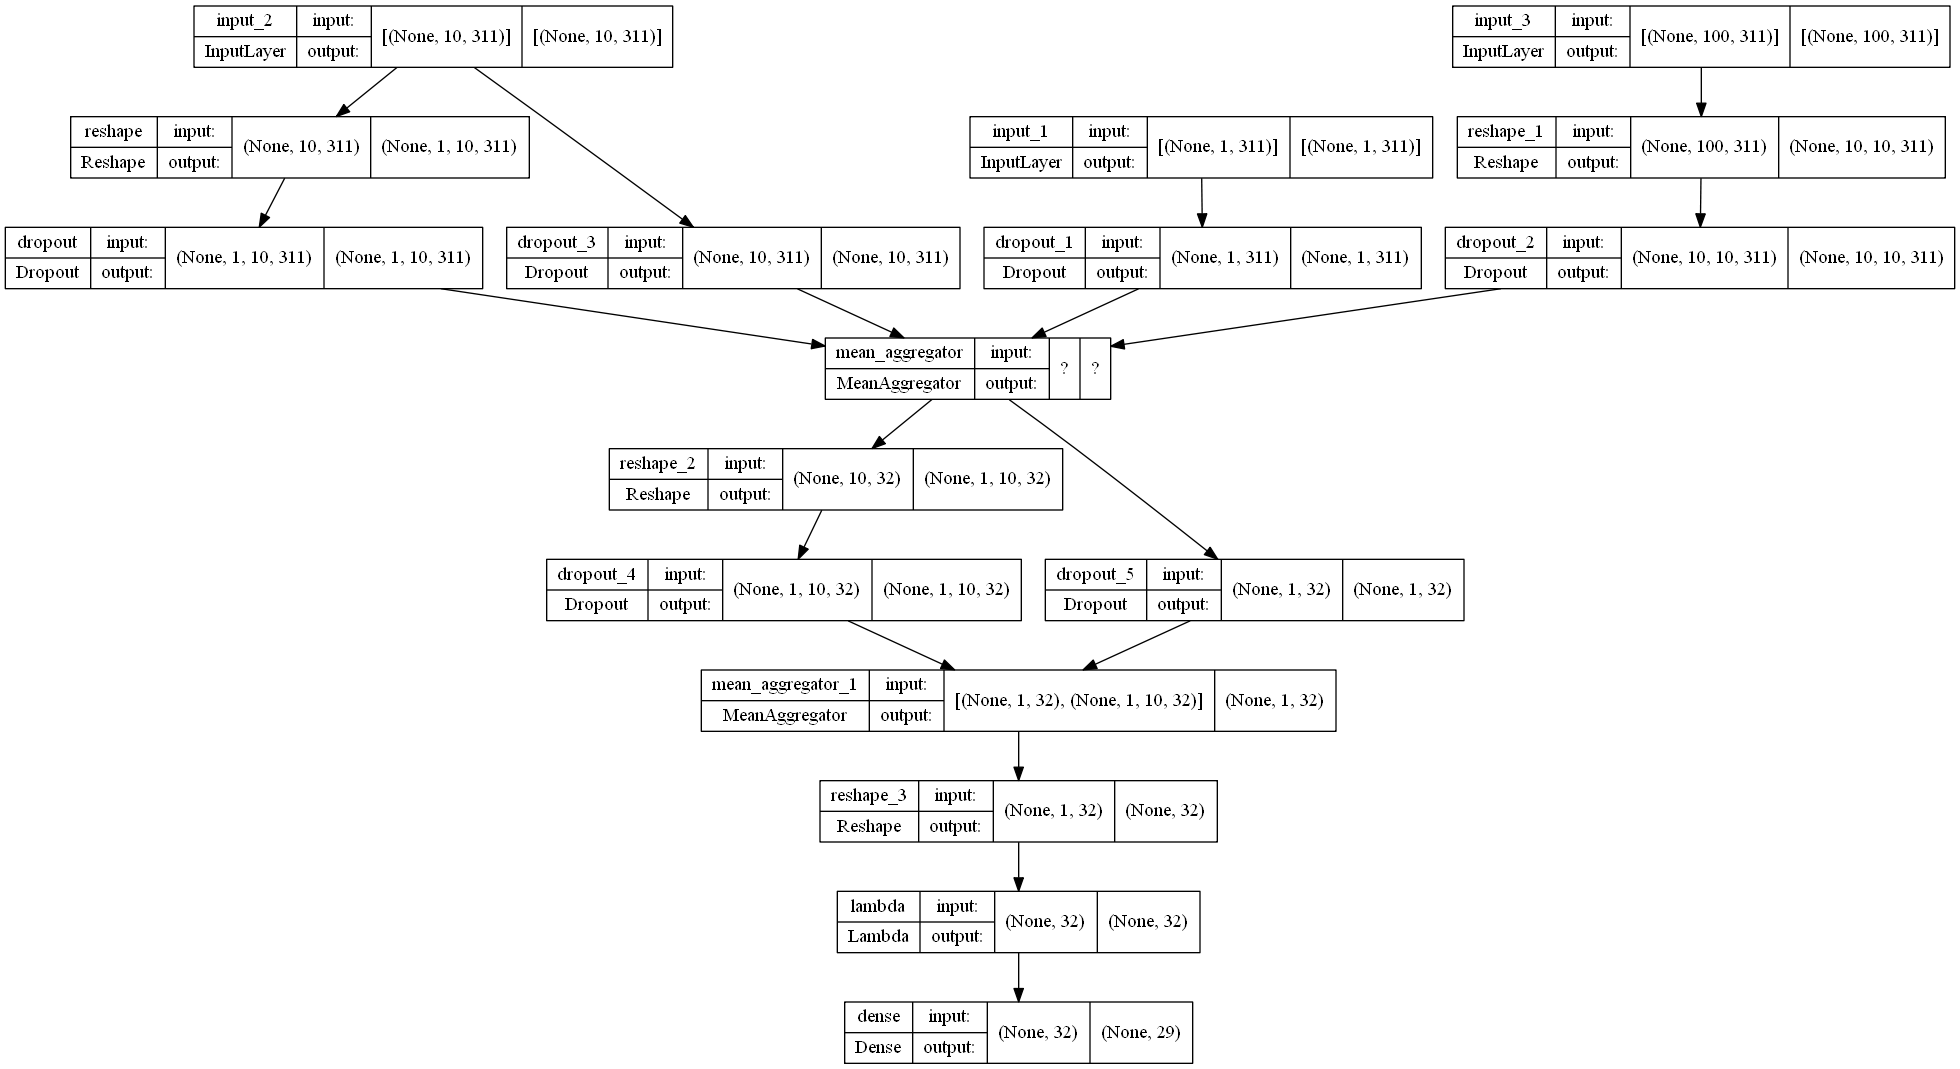

In [19]:
from keras.utils.vis_utils import plot_model

# Preview model
plot_model(graph_sage_model, to_file=os.path.join(models_dir, 'graph_sage_model_plot.png'), show_shapes=True, show_layer_names=True)

## Training and Model Performance Plots

In [20]:
# Fit the model and check the result
epochs = 200
patience = 10

early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=1)
graph_sage_history = graph_sage_model.fit(train_gen, epochs=epochs, validation_data=val_gen, shuffle=False, verbose=1, callbacks=[early_stopping])

Epoch 1/200
2722/2722 [==============================] - 114s 41ms/step - loss: 1.0005 - accuracy: 0.6938 - val_loss: 0.6244 - val_accuracy: 0.7801
Epoch 2/200
2722/2722 [==============================] - 105s 39ms/step - loss: 0.7199 - accuracy: 0.7504 - val_loss: 0.5286 - val_accuracy: 0.8061
Epoch 3/200
2722/2722 [==============================] - 92s 34ms/step - loss: 0.6571 - accuracy: 0.7686 - val_loss: 0.4772 - val_accuracy: 0.8323
Epoch 4/200
2722/2722 [==============================] - 111s 41ms/step - loss: 0.6257 - accuracy: 0.7766 - val_loss: 0.4608 - val_accuracy: 0.8403
Epoch 5/200
2722/2722 [==============================] - 121s 45ms/step - loss: 0.6004 - accuracy: 0.7874 - val_loss: 0.4215 - val_accuracy: 0.8507
Epoch 6/200
2722/2722 [==============================] - 121s 45ms/step - loss: 0.5848 - accuracy: 0.7902 - val_loss: 0.4170 - val_accuracy: 0.8504
Epoch 7/200
2722/2722 [==============================] - 123s 45ms/step - loss: 0.5715 - accuracy: 0.7951 - val_l

2722/2722 [==============================] - 105s 38ms/step - loss: 0.4646 - accuracy: 0.8310 - val_loss: 0.2997 - val_accuracy: 0.8919
Epoch 57/200
2722/2722 [==============================] - 100s 37ms/step - loss: 0.4654 - accuracy: 0.8316 - val_loss: 0.3051 - val_accuracy: 0.8899
Epoch 58/200
2722/2722 [==============================] - 102s 38ms/step - loss: 0.4675 - accuracy: 0.8308 - val_loss: 0.3037 - val_accuracy: 0.8908
Epoch 59/200
2722/2722 [==============================] - 96s 35ms/step - loss: 0.4648 - accuracy: 0.8316 - val_loss: 0.3031 - val_accuracy: 0.8921
Epoch 60/200
2722/2722 [==============================] - 102s 37ms/step - loss: 0.4669 - accuracy: 0.8310 - val_loss: 0.3041 - val_accuracy: 0.8900
Epoch 60: early stopping


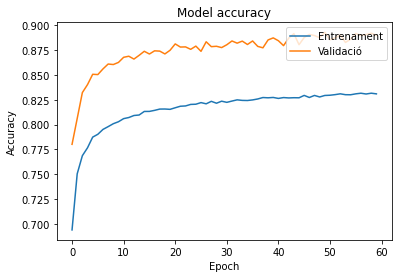

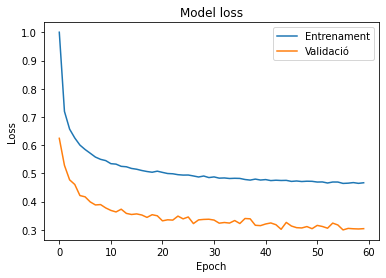

In [21]:
# View two graphs to see how accuracy and error evolve during the training process

# Visualize the evolution of the network accuracy
plt.plot(graph_sage_history.history['accuracy'])
plt.plot(graph_sage_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenament', 'Validació'], loc='upper right')
plt.show()

# Visualize the evolution of the network error
plt.plot(graph_sage_history.history['loss'])
plt.plot(graph_sage_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Entrenament', 'Validació'], loc='upper right')
plt.show()

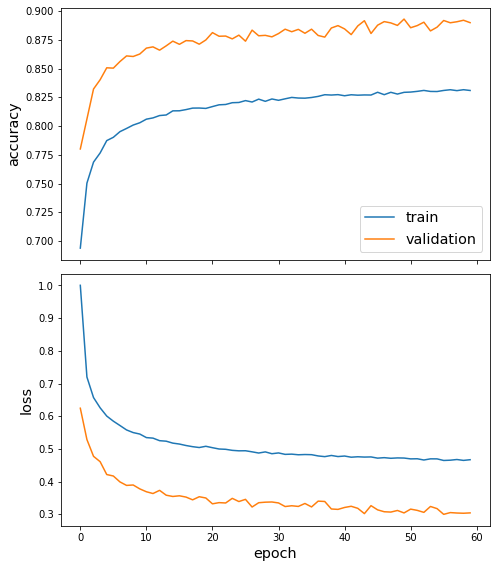

In [22]:
# View two graphs to see how accuracy and error evolve during the training process
utils.plot_history(graph_sage_history)

In [23]:
# Evaluate model performance on Validation Set
val_metrics = graph_sage_model.evaluate(val_gen)
print("\nValidatiom Set Metrics:")

for name, value in zip(graph_sage_model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, value))

2693/2693 [==============================] - 50s 18ms/step - loss: 0.3031 - accuracy: 0.8926

Validatiom Set Metrics:
	loss: 0.3031
	accuracy: 0.8926


In [24]:
from keras.models import load_model
from stellargraph.layer.gcn import GraphConvolution
from stellargraph.layer.misc import GatherIndices, SqueezedSparseConversion

# Save the model
graph_sage_model.save(os.path.join(models_dir, 'graph_sage_model.h5'))

In [26]:
from keras.models import load_model
from stellargraph.layer.graphsage import MeanAggregator 

# Load the model
graph_sage_model = load_model(os.path.join(models_dir, 'graph_sage_model.h5'), custom_objects={'MeanAggregator': MeanAggregator})

### Making predictions with the model

**Validation Set**

In [27]:
# Make predictions on Validation Set
val_gen = generator.flow(val.node_id)
val_predictions = graph_sage_model.predict(val_gen)

In [28]:
# Convert one-hot-encoding label to Text label
val_node_predictions = target_encoding.inverse_transform(val_predictions.squeeze())

val['node_prediction'] = val_node_predictions

val.tail(10)

,node_id,node_target,node_prediction
id,,,
137445,naturedecouvertes217_137445,OTHER,OTHER
137446,naturedecouvertes217_137446,OTHER,OTHER
137447,naturedecouvertes217_137447,SUPPLIER_VAT,SUPPLIER_VAT
137449,naturedecouvertes217_137449,OTHER,OTHER
137450,naturedecouvertes217_137450,OTHER,OTHER
137451,naturedecouvertes217_137451,OTHER,OTHER
137452,naturedecouvertes217_137452,SUPPLIER_FAX_NUMBER,SUPPLIER_FAX_NUMBER
137453,naturedecouvertes217_137453,OTHER,OTHER
137454,naturedecouvertes217_137454,OTHER,OTHER


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate some metrics: precision, recall i f1-score by class on Validation Set.
print('\n Mètriques precision, recall i f1-score obtingudes per classe')
print(classification_report(val.node_target, val_node_predictions))


 Mètriques precision, recall i f1-score obtingudes per classe
                                 precision    recall  f1-score   support

                BILLING_ADDRESS       0.78      0.81      0.79      4623
                   BILLING_NAME       0.76      0.73      0.75      1654
                  CLIENT_NUMBER       0.92      0.95      0.93       300
                          IMAGE       0.97      0.91      0.94       200
                   INVOICE_DATE       0.78      0.89      0.83      2790
                 INVOICE_NUMBER       0.93      0.96      0.94       930
                   ORDER_NUMBER       0.83      0.93      0.88       700
                          OTHER       0.97      0.93      0.95     73444
                   PAYMENT_MODE       0.91      0.98      0.94       430
            PRODUCT_DESCRIPTION       0.92      0.96      0.94     11394
                  PRODUCT_TOTAL       0.81      0.98      0.89       543
PRODUCT_TOTAL_PRICE_WITHOUT_TAX       0.70      0.87      0.


Matriu de confusió


Text(114.0, 0.5, 'Real')

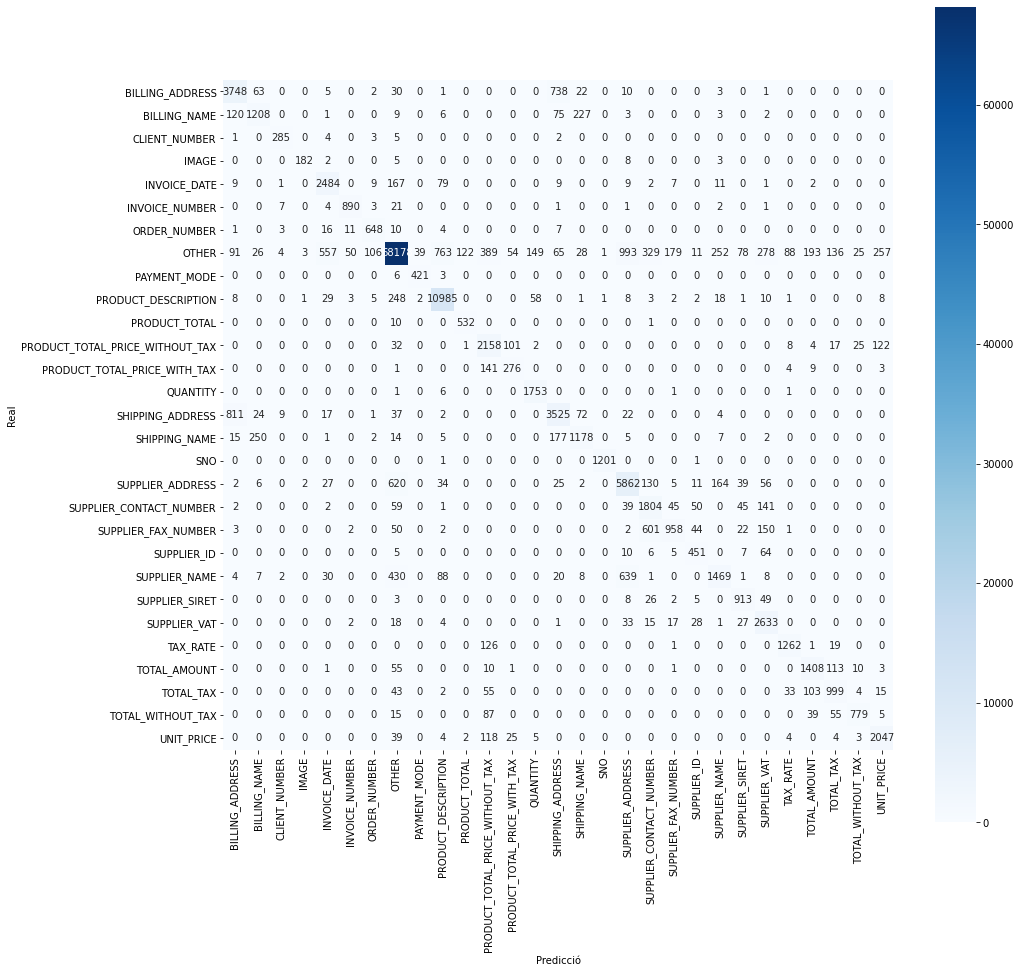

In [30]:
# Visualize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(val.node_target, val_node_predictions)

targets = target_encoding.classes_

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")

**Test Set**

In [31]:
# Create a generator function to generate batches of nodes given the Stellar Network Graph (Train, Validation & Test).
generator = GraphSAGENodeGenerator(graph_full, batch_size, num_samples)

In [32]:
# Call the flow function and pass the target label and the nodes to get an object that can be used as a Keras data generator.
test_gen = generator.flow(test.node_id, test_targets)

In [34]:
# Evaluate model performance on Test Set
test_gen = generator.flow(test.node_id, test_targets)

test_metrics = graph_sage_model.evaluate(test_gen)

print("\nTest Set Metrics:")

for name, val in zip(graph_sage_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1362/1362 [==============================] - 126s 92ms/step - loss: 0.3114 - accuracy: 0.8909

Test Set Metrics:
	loss: 0.3114
	accuracy: 0.8909


In [35]:
test_gen = generator.flow(test.node_id)

test_predictions = graph_sage_model.predict(test_gen)

# Convert one-hot-encoding label to Text label
test_node_predictions = target_encoding.inverse_transform(test_predictions.squeeze())

test['node_prediction'] = test_node_predictions

test.head(10)

,node_id,node_target,node_prediction
id,,,
62801,darty77_62801,SUPPLIER_NAME,SUPPLIER_NAME
62802,darty77_62802,SUPPLIER_NAME,SUPPLIER_NAME
62803,darty77_62803,SUPPLIER_NAME,SUPPLIER_NAME
62828,darty77_62828,SHIPPING_NAME,SHIPPING_ADDRESS
62829,darty77_62829,SHIPPING_NAME,SHIPPING_ADDRESS
62804,darty77_62804,OTHER,SUPPLIER_NAME
62805,darty77_62805,OTHER,SUPPLIER_NAME
62830,darty77_62830,SHIPPING_ADDRESS,SHIPPING_ADDRESS
62831,darty77_62831,SHIPPING_ADDRESS,SHIPPING_ADDRESS


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate some metrics: precision, recall i f1-score by class on Test Set.
print('\n Mètriques precision, recall i f1-score obtingudes per classe')
print(classification_report(test.node_target, test_node_predictions))


 Mètriques precision, recall i f1-score obtingudes per classe
                                 precision    recall  f1-score   support

                BILLING_ADDRESS       0.77      0.80      0.78      2294
                   BILLING_NAME       0.77      0.73      0.75       813
                  CLIENT_NUMBER       0.91      0.96      0.93       150
                          IMAGE       0.94      0.89      0.91       100
                   INVOICE_DATE       0.79      0.89      0.84      1392
                 INVOICE_NUMBER       0.94      0.97      0.95       468
                   ORDER_NUMBER       0.86      0.91      0.88       350
                          OTHER       0.97      0.93      0.95     36887
                   PAYMENT_MODE       0.92      0.97      0.94       215
            PRODUCT_DESCRIPTION       0.92      0.96      0.94      5969
                  PRODUCT_TOTAL       0.80      0.98      0.88       278
PRODUCT_TOTAL_PRICE_WITHOUT_TAX       0.71      0.87      0.


Matriu de confusió


Text(114.0, 0.5, 'Real')

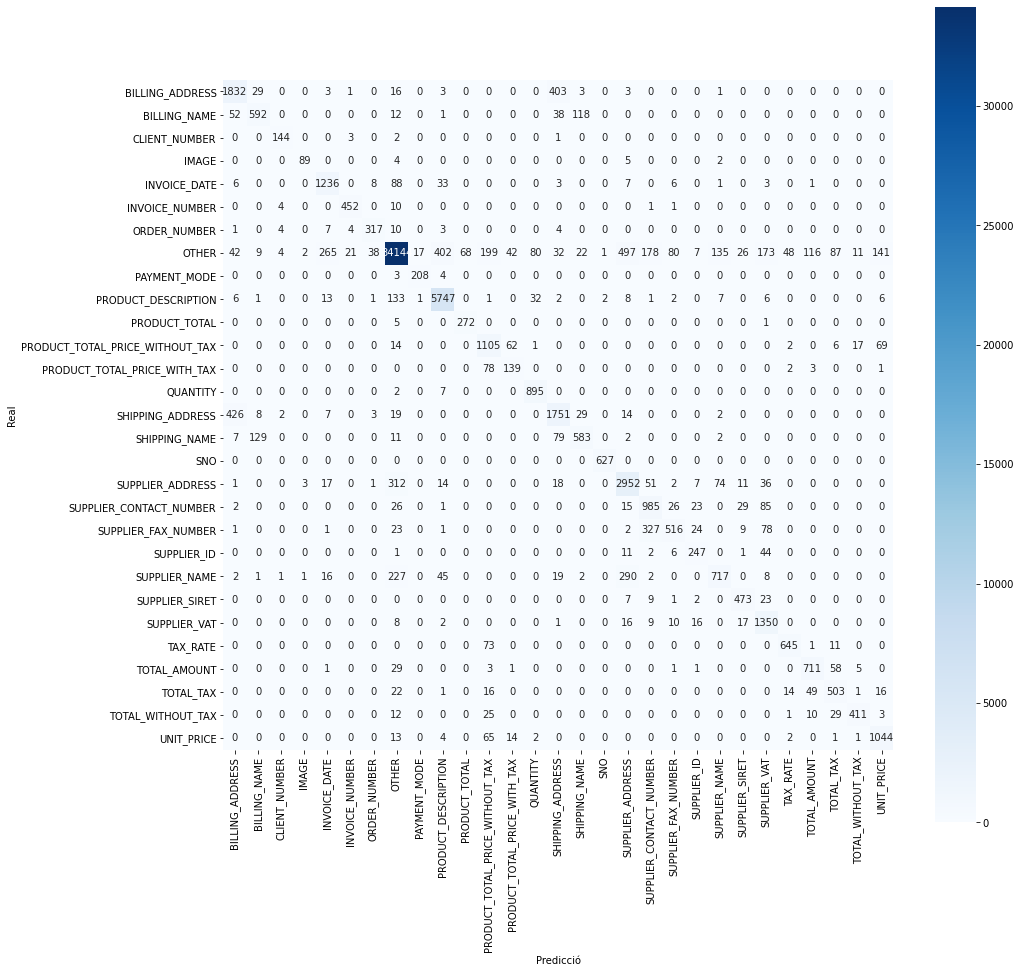

In [37]:
# Visualize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(test.node_target, test_node_predictions)

targets = target_encoding.classes_

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")


Matriu de confusió


Text(114.0, 0.5, 'Real')

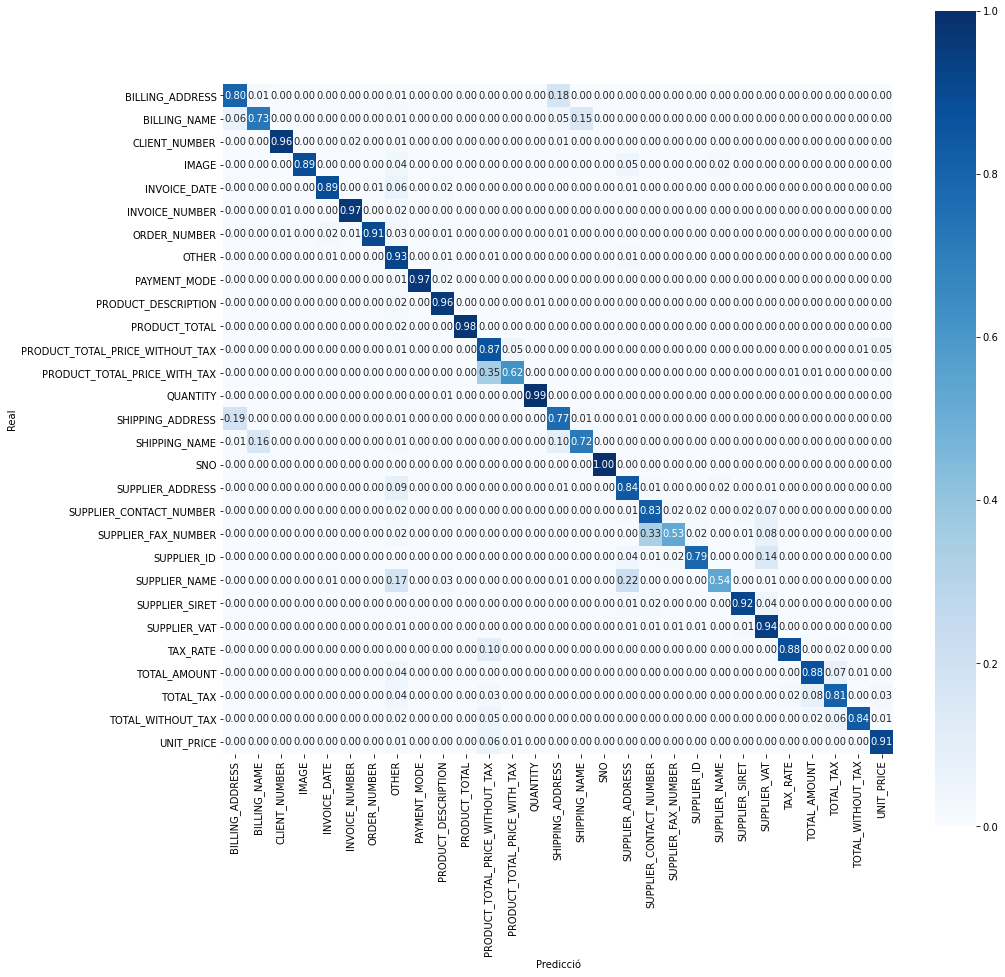

In [52]:
# Visualize normalize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(test.node_target, test_node_predictions, normalize='true')

targets = target_encoding.classes_

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2f', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")

### Node embeddings for test nodes

We are going to extract node embeddings as activations of the output of GraphSAGE layer stack, and visualise them, coloring nodes by their class label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the x_out variable. Let’s create a new model with the same inputs as we used previously x_inp but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [38]:
graphsage_model = GraphSAGE(layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5)
x_inp, x_out = graphsage_model.in_out_tensors()

embedding_model = Model(inputs=x_inp, outputs=x_out)

In [39]:
emb = embedding_model.predict(test_gen)
emb.shape

(68079, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their class label

In [40]:
X = emb
y = np.argmax(test_targets, axis=1)

In [41]:
if X.shape[1] > 2:
    transform = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X)  # PCA

    emb_transformed = pd.DataFrame(transform, index=test.node_id)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=test.node_id)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

C:\Users\Albert\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


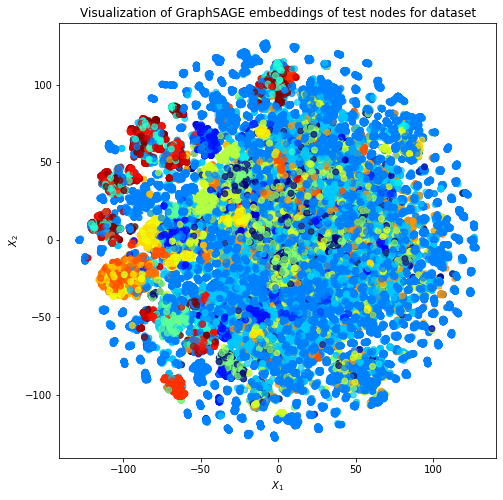

In [42]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("Visualization of GraphSAGE embeddings of test nodes for dataset")
plt.show()